In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install tensorboard

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.



In [6]:
import torchvision.models as models


In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


class MyDataset(Dataset):
    def __init__(self, folder_path):
        self.data = []
        self.labels = []
        self.max_length = 0
        self.feature_count = 0
        label_map = {}  # 用于映射字符标签到整数标签的字典
        label_index = 0
        for file_name in os.listdir(folder_path):
            if file_name.endswith('embedding_txt'):
                self.feature_count += 1
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as f:
                    for line in f:
                        mfcc_features = [float(x) for x in line.split()]
                        if len(mfcc_features) > self.max_length:
                           self.max_length = len(mfcc_features)
        dataset_size = self.feature_count
        print("Feature amounts: ",self.feature_count)
        print("Dataset size: ",dataset_size)
                    
        for file_name in os.listdir(folder_path):
            if file_name.endswith('embedding_txt'):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as f:
                    for line in f:
                        mfcc_features = [float(x) for x in line.split()]
                        # 填充特征向量到相同长度
                        if len(mfcc_features)< self.max_length:
                            mfcc_features = self.paddingByMaxLength(mfcc_features)
                        mfcc_features_tensor = torch.tensor(mfcc_features, dtype=torch.float32)
                        self.data.append(mfcc_features_tensor)
                        speaker_id = os.path.basename(file_path)[:3]
                        if speaker_id not in label_map:
                            label_map[speaker_id] = label_index
                            label_index += 1
                        self.labels.append(label_map[speaker_id])
        print("Label size: ",len(self.labels))
                        
    def paddingByMaxLength(self, features):
        if len(features) < self.max_length:
            padded_features = features + [0.0] * (self.max_length - len(features))
            return padded_features
        return features

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        features_tensor = self.data[idx]
        label_tensor = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return {'features': features_tensor, 'label': label_tensor}


dataset_size = 0       
batch_size = 64
train_path = '../../split_data/train'
valid_path = '../../split_data/validation'
test_path = '../../split_data/test'
train_dataset = MyDataset(train_path)
val_dataset = MyDataset(valid_path)
test_dataset = MyDataset(test_path)
def train_dataloader(train_dataset):
        return DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

def val_dataloader(val_dataset):
        return DataLoader(dataset=val_dataset, batch_size=batch_size)

def test_dataloader(test_dataset):
        return DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#loading dataloader
trainloader = train_dataloader(train_dataset)
validationloader = val_dataloader(val_dataset)
testloader = test_dataloader(test_dataset)


Feature amounts:  729
Dataset size:  729
Label size:  729
Feature amounts:  149
Dataset size:  149
Label size:  149
Feature amounts:  140
Dataset size:  140
Label size:  140


In [24]:
from PIL import Image
from torchvision import transforms

class MyMelDataset(Dataset):
    
    def __init__(self, folder_path,transform):
        self.transform = transform
        self.data = []
        self.labels = []
        self.feature_count = 0
        label_map = {}  # 用于映射字符标签到整数标签的字典
        label_index = 0
        for file_name in os.listdir(folder_path):
            if file_name.endswith('png'):
                self.feature_count += 1
                img_name = os.path.join(folder_path,file_name)
                image = Image.open(img_name)
                image_tensor = self.transform(image)
                self.data.append(image_tensor)
                speaker_id = os.path.basename(file_name)[:3]
                if speaker_id not in label_map:
                            label_map[speaker_id] = label_index
                            label_index += 1
                self.labels.append(label_map[speaker_id])
        print("Feature amounts: ", self.feature_count)        
        print("Label size: ",len(self.labels))
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        features_tensor = self.data[idx]
        label_tensor = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return {'features': features_tensor, 'label': label_tensor}
    
transform = transforms.Compose([
    transforms.Resize((279, 109)),  # 调整图像大小
    transforms.ToTensor(),           # 转换为张量
    transforms.Normalize(mean=[0.5], std=[0.5])  # 标准化
])

train_path_Mel = '../../split_data/train_Mel'
valid_path_Mel = '../../split_data/validation_Mel'
test_path_Mel = '../../split_data/test_Mel'

train_dataset_Mel= MyMelDataset(train_path_Mel,transform=transform)
val_dataset_Mel = MyMelDataset(valid_path_Mel,transform = transform)
test_dataset_Mel = MyMelDataset(test_path_Mel, transform= transform)

trainloader_Mel = train_dataloader(train_dataset_Mel)
validationloader_Mel = val_dataloader(val_dataset_Mel)
testloader_Mel = test_dataloader(test_dataset_Mel)

Feature amounts:  608
Label size:  608
Feature amounts:  76
Label size:  76
Feature amounts:  76
Label size:  76


In [11]:

for data in trainloader_Mel:
    print("Features shape:", data['features'].shape)
    print("Labels shape:", data['label'].shape)
    print(data['label'])

Features shape: torch.Size([64, 4, 224, 224])
Labels shape: torch.Size([64])
tensor([2, 9, 5, 8, 4, 2, 5, 3, 5, 0, 3, 1, 4, 4, 7, 7, 4, 8, 0, 1, 2, 2, 3, 3,
        7, 4, 7, 5, 5, 2, 0, 8, 0, 9, 8, 3, 5, 1, 0, 5, 3, 3, 2, 4, 6, 0, 9, 1,
        5, 2, 8, 5, 8, 9, 6, 7, 0, 9, 3, 2, 4, 5, 1, 4])
Features shape: torch.Size([64, 4, 224, 224])
Labels shape: torch.Size([64])
tensor([7, 7, 3, 6, 9, 6, 0, 2, 1, 5, 9, 9, 0, 3, 7, 2, 7, 2, 5, 7, 5, 0, 2, 1,
        7, 7, 3, 1, 2, 9, 7, 3, 2, 9, 9, 2, 2, 5, 3, 5, 0, 5, 9, 7, 4, 7, 4, 9,
        3, 0, 0, 2, 5, 3, 4, 3, 3, 8, 1, 3, 2, 7, 5, 0])
Features shape: torch.Size([64, 4, 224, 224])
Labels shape: torch.Size([64])
tensor([5, 5, 2, 7, 6, 9, 2, 5, 7, 3, 3, 8, 3, 9, 4, 9, 0, 5, 1, 0, 6, 3, 5, 3,
        0, 6, 2, 2, 9, 0, 7, 4, 9, 9, 0, 9, 2, 3, 2, 0, 2, 7, 4, 2, 5, 4, 2, 5,
        5, 3, 4, 9, 0, 2, 5, 5, 9, 7, 3, 1, 2, 4, 9, 7])
Features shape: torch.Size([64, 4, 224, 224])
Labels shape: torch.Size([64])
tensor([5, 6, 9, 9, 9, 9, 0, 4, 9, 5, 1, 

In [12]:
resNetModel = models.resnet50(pretrained = True)
# 获取第一个卷积层的权重
conv1_weight = resNetModel.conv1.weight

# 将通道数修改为1
modified_conv1_weight = conv1_weight[:, :1, :, :]

# 修改模型的第一个卷积层的权重
#resNetModel.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resNetModel.conv1.weight.data = modified_conv1_weight

# 检查修改后的模型结构
print(resNetModel)

E:\Studying soft\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Studying soft\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Number of mini-batches in one epoch: 12
Epoch 1, Batch 12, Loss: 0.373294
Epoch 1, Validation Accuracy: 22.818792%
Best model saved with validation accuracy: 22.818791946308725
Epoch 2, Batch 12, Loss: 0.160209
Epoch 2, Validation Accuracy: 28.859060%
Best model saved with validation accuracy: 28.859060402684566
Epoch 3, Batch 12, Loss: 0.128480
Epoch 3, Validation Accuracy: 40.268456%
Best model saved with validation accuracy: 40.26845637583892
Epoch 4, Batch 12, Loss: 0.110256
Epoch 4, Validation Accuracy: 40.939597%
Best model saved with validation accuracy: 40.939597315436245
Epoch 5, Batch 12, Loss: 0.084379
Epoch 5, Validation Accuracy: 42.953020%
Best model saved with validation accuracy: 42.95302013422819
Epoch 6, Batch 12, Loss: 0.074041
Epoch 6, Validation Accuracy: 43.624161%
Best model saved with validation accuracy: 43.624161073825505
Epoch 7, Batch 12, Loss: 0.070902
Epoch 7, Validation Accuracy: 45.637584%
Best model saved with validation accuracy: 45.63758389261745
Epoc

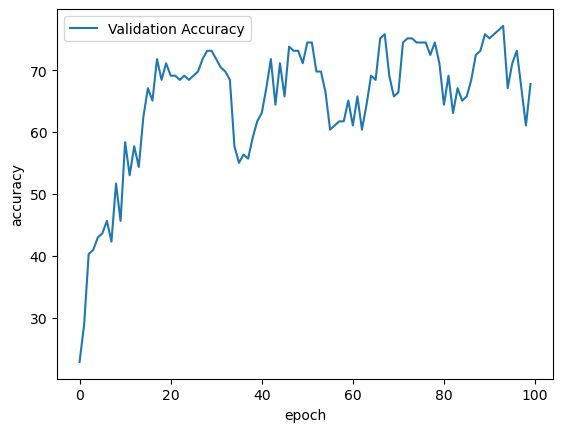

In [13]:
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNetModel.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resNetModel.parameters(), lr=0.001)

log_dir = "./logs/resNet50"
writer = SummaryWriter(log_dir)

best_accuracy = 0.0  # 初始化最佳准确率为0
best_model_path = "./best_restNetmodel.pth"  # 模型保存路径

train_losses = []
validations = []
print("Number of mini-batches in one epoch:", len(trainloader))
for epoch in range(100):
    running_loss = 0.0  
    for i, data in enumerate(trainloader, 0):
        inputs_origin = data['features']
        inputs_new = inputs_origin.unsqueeze(1).unsqueeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        optimizer.zero_grad()

        outputs = resNetModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % len(trainloader) == len(trainloader) - 1:
            average_loss = running_loss / 100
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {average_loss:.6f}")

            train_losses.append(average_loss)

            running_loss = 0.0

    # 在每个epoch结束后执行验证集评估
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            inputs_origin = data['features']
            inputs_new = inputs_origin.unsqueeze(1).unsqueeze(2)
            inputs, labels = inputs_new.to(device), data['label'].to(device)
            outputs = resNetModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    validations.append(accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.6f}%")

    # 如果当前模型在验证集上表现优于之前的最佳表现，则保存当前模型参数
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(resNetModel.state_dict(), best_model_path)
        print("Best model saved with validation accuracy:", best_accuracy)
    
plt.plot(validations, label = "Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
print("resNetModel Training finished")

In [15]:
mobileNetModel = models.mobilenet_v2(pretrained = True)
# 修改第一个卷积层的输入通道数
mobileNetModel.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# 打印修改后的模型结构
print(mobileNetModel)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

E:\Studying soft\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of mini-batches in one epoch: 12
Epoch 1, Batch 12, Loss: 0.219097
Epoch 1, Validation Accuracy: 32.885906%
Best model saved with validation accuracy: 32.88590604026846
Epoch 2, Batch 12, Loss: 0.128120
Epoch 2, Validation Accuracy: 42.281879%
Best model saved with validation accuracy: 42.281879194630875
Epoch 3, Batch 12, Loss: 0.073744
Epoch 3, Validation Accuracy: 53.020134%
Best model saved with validation accuracy: 53.02013422818792
Epoch 4, Batch 12, Loss: 0.052013
Epoch 4, Validation Accuracy: 63.758389%
Best model saved with validation accuracy: 63.758389261744966
Epoch 5, Batch 12, Loss: 0.036154
Epoch 5, Validation Accuracy: 69.127517%
Best model saved with validation accuracy: 69.12751677852349
Epoch 6, Batch 12, Loss: 0.023375
Epoch 6, Validation Accuracy: 64.429530%
Epoch 7, Batch 12, Loss: 0.015702
Epoch 7, Validation Accuracy: 65.100671%
Epoch 8, Batch 12, Loss: 0.012873
Epoch 8, Validation Accuracy: 67.785235%
Epoch 9, Batch 12, Loss: 0.009116
Epoch 9, Validation

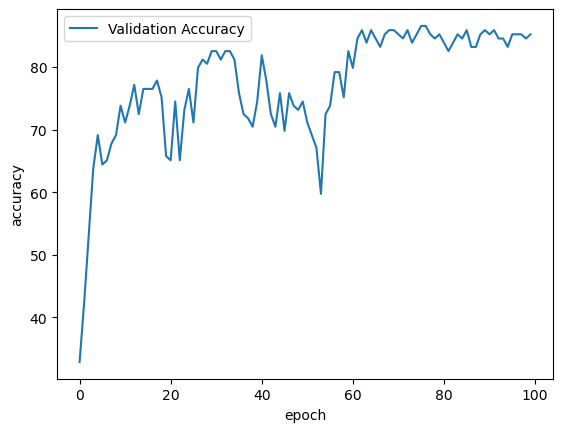

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobileNetModel.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobileNetModel.parameters(), lr=0.001)

log_dir = "./logs/mobileNet_v2"
writer = SummaryWriter(log_dir)

best_accuracy = 0.0  # 初始化最佳准确率为0
best_model_path = "./best_mobilemodel.pth"  # 模型保存路径

validations = []

print("Number of mini-batches in one epoch:", len(trainloader))
for epoch in range(100):
    running_loss = 0.0  
    for i, data in enumerate(trainloader, 0):
        inputs_origin = data['features']
        inputs_new = inputs_origin.unsqueeze(1).unsqueeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        optimizer.zero_grad()

        outputs = mobileNetModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % len(trainloader) == len(trainloader) - 1:
            average_loss = running_loss / 100
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {average_loss:.6f}")

            global_step = epoch * len(trainloader) + i
            writer.add_scalar("Loss", average_loss, global_step)

            running_loss = 0.0

    # 在每个epoch结束后执行验证集评估
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            inputs_origin = data['features']
            inputs_new = inputs_origin.unsqueeze(1).unsqueeze(2)
            inputs, labels = inputs_new.to(device), data['label'].to(device)
            outputs = mobileNetModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    validations.append(accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.6f}%")

    # 如果当前模型在验证集上表现优于之前的最佳表现，则保存当前模型参数
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(mobileNetModel.state_dict(), best_model_path)
        print("Best model saved with validation accuracy:", best_accuracy)
        
plt.plot(validations, label = "Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
print("mobileNetModel Training finished")

In [20]:
denseNetModel = models.densenet201(pretrained = True)
# 修改第一个卷积层的输入通道数
denseNetModel.features.conv0 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# 打印修改后的模型结构
print(denseNetModel)

E:\Studying soft\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Studying soft\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Number of mini-batches in one epoch: 12
Epoch 1, Validation Accuracy: 60.526316%
Best model saved with validation accuracy: 60.526315789473685
Epoch 2, Validation Accuracy: 76.315789%
Best model saved with validation accuracy: 76.31578947368422
Epoch 3, Validation Accuracy: 80.263158%
Best model saved with validation accuracy: 80.26315789473685
Epoch 4, Validation Accuracy: 81.578947%
Best model saved with validation accuracy: 81.57894736842105
Epoch 5, Validation Accuracy: 84.210526%
Best model saved with validation accuracy: 84.21052631578947
Epoch 6, Validation Accuracy: 80.263158%
Epoch 7, Validation Accuracy: 84.210526%
Epoch 8, Validation Accuracy: 78.947368%
Epoch 9, Validation Accuracy: 82.894737%
Epoch 10, Validation Accuracy: 82.894737%
Epoch 11, Validation Accuracy: 85.526316%
Best model saved with validation accuracy: 85.52631578947368
Epoch 12, Validation Accuracy: 82.894737%
Epoch 13, Validation Accuracy: 85.526316%
Epoch 14, Validation Accuracy: 85.526316%
Epoch 15, Vali

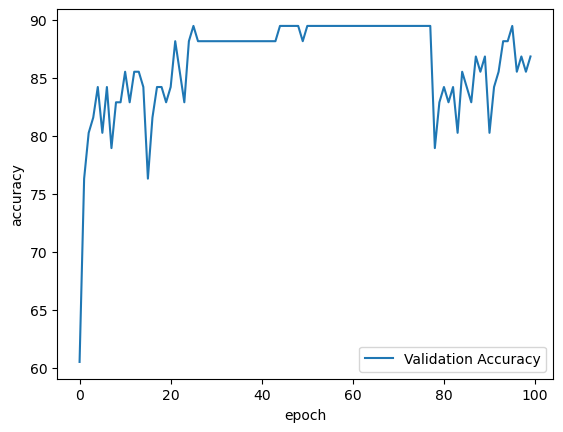

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
denseNetModel.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(denseNetModel.parameters(), lr=0.001)

log_dir = "./logs/resNet50"
writer = SummaryWriter(log_dir)

best_accuracy = 0.0  # 初始化最佳准确率为0
best_model_path = "./best_restNetmodel.pth"  # 模型保存路径
validations = []

print("Number of mini-batches in one epoch:", len(trainloader))
for epoch in range(100):
    running_loss = 0.0  
    for i, data in enumerate(trainloader_Mel, 0):
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        optimizer.zero_grad()

        outputs = denseNetModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % len(trainloader) == len(trainloader) - 1:
            average_loss = running_loss / 100
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {average_loss:.6f}")

            global_step = epoch * len(trainloader) + i
            writer.add_scalar("Loss", average_loss, global_step)

            running_loss = 0.0

    # 在每个epoch结束后执行验证集评估
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader_Mel:
            inputs_origin = data['features']
            inputs_new = inputs_origin.squeeze(1).squeeze(2)
            inputs, labels = inputs_new.to(device), data['label'].to(device)
            outputs = denseNetModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    validations.append(accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.6f}%")

    # 如果当前模型在验证集上表现优于之前的最佳表现，则保存当前模型参数
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        
        torch.save(denseNetModel.state_dict(), best_model_path)
        print("Best model saved with validation accuracy:", best_accuracy)

plt.plot(validations, label = "Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
print("mobileNetModel Training finished")
print("denseNetModel Training finished")